<a href="https://colab.research.google.com/github/lcqsigi/big-data2/blob/main/ch13_part2_RS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
from sklearn import datasets
import numpy as np
import pandas as pd
iris = datasets.load_iris()
#df = pd.DataFrame(iris['data'], columns=data['feature_names'])
#df['target'] = iris['target']
#df.head()

In [19]:
iris_info

tfds.core.DatasetInfo(
    name='iris',
    full_name='iris/2.0.0',
    description="""
    This is perhaps the best known database to be found in the pattern recognition
    literature. Fisher's paper is a classic in the field and is referenced
    frequently to this day. (See Duda & Hart, for example.) The data set contains
    3 classes of 50 instances each, where each class refers to a type of iris
    plant. One class is linearly separable from the other 2; the latter are NOT
    linearly separable from each other.
    """,
    homepage='https://archive.ics.uci.edu/ml/datasets/iris',
    data_path='/root/tensorflow_datasets/iris/2.0.0',
    file_format=tfrecord,
    download_size=4.44 KiB,
    dataset_size=7.62 KiB,
    features=FeaturesDict({
        'features': Tensor(shape=(4,), dtype=float32),
        'label': ClassLabel(shape=(), dtype=int64, num_classes=3),
    }),
    supervised_keys=('features', 'label'),
    disable_shuffling=False,
    splits={
        'train': <SplitInf

In [4]:
import tensorflow_datasets as tfds
iris, iris_info = tfds.load('iris', with_info=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/iris/2.0.0.incomplete4EQ9SE/iris-train.tfrecord*...:   0%|          | 0/15…

Dataset iris downloaded and prepared to /root/tensorflow_datasets/iris/2.0.0. Subsequent calls will reuse this data.


In [5]:
tf.random.set_seed(1)

ds_orig = iris['train']
ds_orig = ds_orig.shuffle(150, reshuffle_each_iteration=False)

print(next(iter(ds_orig)))

ds_train_orig = ds_orig.take(100)
ds_test = ds_orig.skip(100)

{'features': <tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>, 'label': <tf.Tensor: shape=(), dtype=int64, numpy=2>}


In [6]:
## checking the number of examples:

n = 0
for example in ds_train_orig:
    n += 1
print(n)


n = 0
for example in ds_test:
    n += 1
print(n)

100
50


In [7]:
ds_train_orig = ds_train_orig.map(
    lambda x: (x['features'], x['label']))

ds_test = ds_test.map(
    lambda x: (x['features'], x['label']))

next(iter(ds_train_orig))

(<tf.Tensor: shape=(4,), dtype=float32, numpy=array([6.5, 3. , 5.2, 2. ], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=int64, numpy=2>)

In [8]:
iris_model = tf.keras.Sequential([
    tf.keras.layers.Dense(16, activation='sigmoid', 
                          name='fc1', input_shape=(4,)),
    tf.keras.layers.Dense(3, name='fc2', activation='softmax')])

iris_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [9]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

In [10]:
num_epochs = 100
training_size = 100
batch_size = 2
steps_per_epoch = np.ceil(training_size / batch_size)

ds_train = ds_train_orig.shuffle(buffer_size=training_size)
ds_train = ds_train.repeat()
ds_train = ds_train.batch(batch_size=batch_size)
ds_train = ds_train.prefetch(buffer_size=1000)


history = iris_model.fit(ds_train, epochs=num_epochs,
                         steps_per_epoch=steps_per_epoch, 
                         verbose=0)

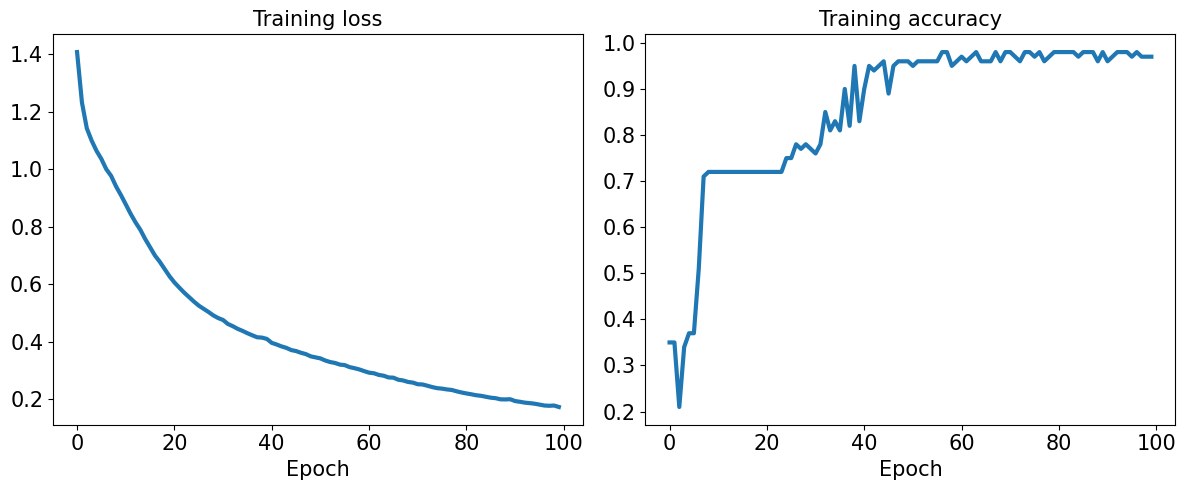

In [11]:
hist = history.history

fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(hist['loss'], lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(hist['accuracy'], lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()
#plt.savefig('ch13-cls-learning-curve.pdf')

plt.show()

### Evaluating the trained model on the test dataset

In [12]:
results = iris_model.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1814   Test Acc.: 0.9800


### Saving and reloading the trained model

In [13]:
iris_model.save('iris-classifier.h5', 
                overwrite=True,
                include_optimizer=True,
                save_format='h5')

In [14]:
iris_model_new = tf.keras.models.load_model('iris-classifier.h5')

iris_model_new.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 fc1 (Dense)                 (None, 16)                80        
                                                                 
 fc2 (Dense)                 (None, 3)                 51        
                                                                 
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [15]:
results = iris_model_new.evaluate(ds_test.batch(50), verbose=0)
print('Test loss: {:.4f}   Test Acc.: {:.4f}'.format(*results))

Test loss: 0.1814   Test Acc.: 0.9800


In [16]:
labels_train = []
for i,item in enumerate(ds_train_orig):
    labels_train.append(item[1].numpy())
    
labels_test = []
for i,item in enumerate(ds_test):
    labels_test.append(item[1].numpy())
print('Training Set: ',len(labels_train), 'Test Set: ', len(labels_test))

Training Set:  100 Test Set:  50


In [17]:
iris_model_new.to_json()

'{"class_name": "Sequential", "config": {"name": "sequential", "layers": [{"class_name": "InputLayer", "config": {"batch_input_shape": [null, 4], "dtype": "float32", "sparse": false, "ragged": false, "name": "fc1_input"}}, {"class_name": "Dense", "config": {"name": "fc1", "trainable": true, "dtype": "float32", "batch_input_shape": [null, 4], "units": 16, "activation": "sigmoid", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regularizer": null, "activity_regularizer": null, "kernel_constraint": null, "bias_constraint": null}}, {"class_name": "Dense", "config": {"name": "fc2", "trainable": true, "dtype": "float32", "units": 3, "activation": "softmax", "use_bias": true, "kernel_initializer": {"class_name": "GlorotUniform", "config": {"seed": null}}, "bias_initializer": {"class_name": "Zeros", "config": {}}, "kernel_regularizer": null, "bias_regu